In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
#     eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
#     aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.6931 eloss:3.1392 aloss2:2.3696 exploreP:0.9984
Episode:1 meanR:19.0000 R:22.0000 rate:0.0440 aloss:0.6916 eloss:3.1272 aloss2:2.3588 exploreP:0.9962
Episode:2 meanR:25.0000 R:37.0000 rate:0.0740 aloss:0.6888 eloss:3.1145 aloss2:2.3468 exploreP:0.9926
Episode:3 meanR:25.2500 R:26.0000 rate:0.0520 aloss:0.6880 eloss:3.0853 aloss2:2.3367 exploreP:0.9901
Episode:4 meanR:25.8000 R:28.0000 rate:0.0560 aloss:0.6862 eloss:3.0933 aloss2:2.3316 exploreP:0.9873
Episode:5 meanR:23.5000 R:12.0000 rate:0.0240 aloss:0.6897 eloss:3.0529 aloss2:2.3217 exploreP:0.9861
Episode:6 meanR:23.0000 R:20.0000 rate:0.0400 aloss:0.6868 eloss:3.0650 aloss2:2.3152 exploreP:0.9842
Episode:7 meanR:25.2500 R:41.0000 rate:0.0820 aloss:0.6869 eloss:3.0576 aloss2:2.3072 exploreP:0.9802
Episode:8 meanR:25.1111 R:24.0000 rate:0.0480 aloss:0.6844 eloss:3.0552 aloss2:2.2969 exploreP:0.9779
Episode:9 meanR:24.6000 R:20.0000 rate:0.0400 aloss:0.6841 eloss:3.0342 aloss2:2.2

Episode:80 meanR:25.2222 R:13.0000 rate:0.0260 aloss:0.6812 eloss:3.3953 aloss2:2.2002 exploreP:0.8171
Episode:81 meanR:25.1341 R:18.0000 rate:0.0360 aloss:0.6979 eloss:3.3883 aloss2:2.2057 exploreP:0.8156
Episode:82 meanR:25.1205 R:24.0000 rate:0.0480 aloss:0.7002 eloss:3.3405 aloss2:2.1964 exploreP:0.8137
Episode:83 meanR:25.5595 R:62.0000 rate:0.1240 aloss:0.6856 eloss:3.3493 aloss2:2.2063 exploreP:0.8087
Episode:84 meanR:25.4353 R:15.0000 rate:0.0300 aloss:0.6900 eloss:3.3222 aloss2:2.2060 exploreP:0.8075
Episode:85 meanR:25.4302 R:25.0000 rate:0.0500 aloss:0.6949 eloss:3.3302 aloss2:2.2082 exploreP:0.8055
Episode:86 meanR:25.4483 R:27.0000 rate:0.0540 aloss:0.6972 eloss:3.3324 aloss2:2.2080 exploreP:0.8034
Episode:87 meanR:25.6364 R:42.0000 rate:0.0840 aloss:0.6920 eloss:3.3130 aloss2:2.2091 exploreP:0.8001
Episode:88 meanR:25.6966 R:31.0000 rate:0.0620 aloss:0.6881 eloss:3.2958 aloss2:2.2087 exploreP:0.7976
Episode:89 meanR:25.8111 R:36.0000 rate:0.0720 aloss:0.6995 eloss:3.2845 

Episode:159 meanR:24.8700 R:13.0000 rate:0.0260 aloss:0.6816 eloss:3.1030 aloss2:2.1740 exploreP:0.6723
Episode:160 meanR:24.8400 R:27.0000 rate:0.0540 aloss:0.6861 eloss:3.1026 aloss2:2.1713 exploreP:0.6705
Episode:161 meanR:24.7200 R:27.0000 rate:0.0540 aloss:0.6919 eloss:3.1030 aloss2:2.1740 exploreP:0.6687
Episode:162 meanR:24.6400 R:16.0000 rate:0.0320 aloss:0.6860 eloss:3.1082 aloss2:2.1783 exploreP:0.6677
Episode:163 meanR:24.7700 R:24.0000 rate:0.0480 aloss:0.6883 eloss:3.1057 aloss2:2.1804 exploreP:0.6661
Episode:164 meanR:24.7800 R:20.0000 rate:0.0400 aloss:0.6829 eloss:3.0993 aloss2:2.1773 exploreP:0.6648
Episode:165 meanR:24.2300 R:12.0000 rate:0.0240 aloss:0.6965 eloss:3.1184 aloss2:2.1791 exploreP:0.6640
Episode:166 meanR:24.1800 R:16.0000 rate:0.0320 aloss:0.6846 eloss:3.0996 aloss2:2.1728 exploreP:0.6630
Episode:167 meanR:24.1300 R:26.0000 rate:0.0520 aloss:0.6857 eloss:3.0925 aloss2:2.1736 exploreP:0.6613
Episode:168 meanR:24.0400 R:12.0000 rate:0.0240 aloss:0.6951 elo

Episode:238 meanR:35.0700 R:42.0000 rate:0.0840 aloss:0.6803 eloss:3.0401 aloss2:2.1630 exploreP:0.5019
Episode:239 meanR:36.3900 R:152.0000 rate:0.3040 aloss:0.6711 eloss:3.0426 aloss2:2.1674 exploreP:0.4945
Episode:240 meanR:37.6400 R:141.0000 rate:0.2820 aloss:0.6746 eloss:3.0479 aloss2:2.1673 exploreP:0.4877
Episode:241 meanR:37.7000 R:33.0000 rate:0.0660 aloss:0.6734 eloss:3.0481 aloss2:2.1706 exploreP:0.4861
Episode:242 meanR:39.9700 R:244.0000 rate:0.4880 aloss:0.6743 eloss:3.0494 aloss2:2.1662 exploreP:0.4747
Episode:243 meanR:39.5300 R:42.0000 rate:0.0840 aloss:0.6783 eloss:3.0532 aloss2:2.1670 exploreP:0.4727
Episode:244 meanR:41.0900 R:173.0000 rate:0.3460 aloss:0.6755 eloss:3.0483 aloss2:2.1674 exploreP:0.4648
Episode:245 meanR:41.5800 R:64.0000 rate:0.1280 aloss:0.6800 eloss:3.0541 aloss2:2.1668 exploreP:0.4619
Episode:246 meanR:42.3500 R:104.0000 rate:0.2080 aloss:0.6721 eloss:3.0466 aloss2:2.1701 exploreP:0.4572
Episode:247 meanR:42.7200 R:56.0000 rate:0.1120 aloss:0.687

Episode:316 meanR:282.7100 R:500.0000 rate:1.0000 aloss:0.6550 eloss:2.7901 aloss2:2.5835 exploreP:0.0430
Episode:317 meanR:287.1900 R:500.0000 rate:1.0000 aloss:0.6449 eloss:2.7709 aloss2:2.6186 exploreP:0.0414
Episode:318 meanR:291.7300 R:500.0000 rate:1.0000 aloss:0.6510 eloss:2.8038 aloss2:2.6349 exploreP:0.0399
Episode:319 meanR:296.0500 R:500.0000 rate:1.0000 aloss:0.6448 eloss:2.7944 aloss2:2.6612 exploreP:0.0384
Episode:320 meanR:300.8600 R:500.0000 rate:1.0000 aloss:0.6437 eloss:2.7801 aloss2:2.7141 exploreP:0.0371
Episode:321 meanR:304.3900 R:365.0000 rate:0.7300 aloss:0.6434 eloss:2.7870 aloss2:2.7495 exploreP:0.0361
Episode:322 meanR:306.9100 R:310.0000 rate:0.6200 aloss:0.6240 eloss:2.7462 aloss2:2.7480 exploreP:0.0353
Episode:323 meanR:311.6800 R:500.0000 rate:1.0000 aloss:0.6317 eloss:2.7537 aloss2:2.8063 exploreP:0.0341
Episode:324 meanR:316.3600 R:500.0000 rate:1.0000 aloss:0.6294 eloss:2.7735 aloss2:2.8071 exploreP:0.0329
Episode:325 meanR:320.2200 R:455.0000 rate:0.9

Episode:394 meanR:326.5000 R:500.0000 rate:1.0000 aloss:0.5763 eloss:2.6840 aloss2:3.4328 exploreP:0.0138
Episode:395 meanR:323.2200 R:172.0000 rate:0.3440 aloss:0.5894 eloss:2.6948 aloss2:3.4477 exploreP:0.0137
Episode:396 meanR:323.2200 R:500.0000 rate:1.0000 aloss:0.5893 eloss:2.6656 aloss2:3.4654 exploreP:0.0135
Episode:397 meanR:320.5200 R:230.0000 rate:0.4600 aloss:0.5864 eloss:2.6741 aloss2:3.4670 exploreP:0.0135
Episode:398 meanR:318.5800 R:306.0000 rate:0.6120 aloss:0.5795 eloss:2.6524 aloss2:3.4645 exploreP:0.0134
Episode:399 meanR:318.5800 R:500.0000 rate:1.0000 aloss:0.5741 eloss:2.6621 aloss2:3.4800 exploreP:0.0132
Episode:400 meanR:318.5800 R:500.0000 rate:1.0000 aloss:0.5714 eloss:2.6472 aloss2:3.4867 exploreP:0.0130
Episode:401 meanR:318.5800 R:500.0000 rate:1.0000 aloss:0.5762 eloss:2.6521 aloss2:3.5077 exploreP:0.0129
Episode:402 meanR:318.5800 R:500.0000 rate:1.0000 aloss:0.5764 eloss:2.6542 aloss2:3.5075 exploreP:0.0128
Episode:403 meanR:318.5800 R:500.0000 rate:1.0

Episode:472 meanR:423.7200 R:500.0000 rate:1.0000 aloss:0.4804 eloss:1.9884 aloss2:4.1376 exploreP:0.0101
Episode:473 meanR:426.8000 R:500.0000 rate:1.0000 aloss:0.4736 eloss:1.9222 aloss2:4.1363 exploreP:0.0101
Episode:474 meanR:430.3400 R:500.0000 rate:1.0000 aloss:0.4757 eloss:1.9578 aloss2:4.1378 exploreP:0.0101
Episode:475 meanR:433.8000 R:500.0000 rate:1.0000 aloss:0.4736 eloss:1.9351 aloss2:4.1765 exploreP:0.0101
Episode:476 meanR:436.5400 R:500.0000 rate:1.0000 aloss:0.4733 eloss:1.9614 aloss2:4.1827 exploreP:0.0101
Episode:477 meanR:439.9300 R:500.0000 rate:1.0000 aloss:0.4738 eloss:1.9754 aloss2:4.1888 exploreP:0.0101
Episode:478 meanR:443.5300 R:500.0000 rate:1.0000 aloss:0.4617 eloss:1.9834 aloss2:4.1940 exploreP:0.0101
Episode:479 meanR:447.0700 R:500.0000 rate:1.0000 aloss:0.4683 eloss:1.9567 aloss2:4.1890 exploreP:0.0101
Episode:480 meanR:450.4100 R:500.0000 rate:1.0000 aloss:0.4691 eloss:1.9789 aloss2:4.1908 exploreP:0.0101
Episode:481 meanR:453.9100 R:500.0000 rate:1.0

Episode:550 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4223 eloss:1.3181 aloss2:6.2091 exploreP:0.0100
Episode:551 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4221 eloss:1.3272 aloss2:6.2573 exploreP:0.0100
Episode:552 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4194 eloss:1.3247 aloss2:6.3058 exploreP:0.0100
Episode:553 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4211 eloss:1.3181 aloss2:6.3382 exploreP:0.0100
Episode:554 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4196 eloss:1.3233 aloss2:6.3546 exploreP:0.0100
Episode:555 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4203 eloss:1.3259 aloss2:6.3498 exploreP:0.0100
Episode:556 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4199 eloss:1.2996 aloss2:6.4017 exploreP:0.0100
Episode:557 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4218 eloss:1.2921 aloss2:6.4459 exploreP:0.0100
Episode:558 meanR:498.7800 R:500.0000 rate:1.0000 aloss:0.4212 eloss:1.2970 aloss2:6.4953 exploreP:0.0100
Episode:559 meanR:498.7800 R:500.0000 rate:1.0

Episode:627 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.4005 eloss:0.1916 aloss2:14.5346 exploreP:0.0100
Episode:628 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.4003 eloss:0.2139 aloss2:14.5992 exploreP:0.0100
Episode:629 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.3998 eloss:0.2152 aloss2:14.6923 exploreP:0.0100
Episode:630 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.4009 eloss:0.2490 aloss2:14.7401 exploreP:0.0100
Episode:631 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.4003 eloss:0.2327 aloss2:14.8578 exploreP:0.0100
Episode:632 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.4001 eloss:0.2204 aloss2:14.9859 exploreP:0.0100
Episode:633 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.4000 eloss:0.2230 aloss2:15.0528 exploreP:0.0100
Episode:634 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.4003 eloss:0.2172 aloss2:15.1920 exploreP:0.0100
Episode:635 meanR:498.9300 R:500.0000 rate:1.0000 aloss:0.3998 eloss:0.1879 aloss2:15.3345 exploreP:0.0100
Episode:636 meanR:498.9300 R:500.0000

Episode:704 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3714 eloss:-1.0737 aloss2:26.0222 exploreP:0.0100
Episode:705 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3697 eloss:-1.0672 aloss2:26.0961 exploreP:0.0100
Episode:706 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3691 eloss:-1.1454 aloss2:26.4066 exploreP:0.0100
Episode:707 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3688 eloss:-1.2056 aloss2:26.5874 exploreP:0.0100
Episode:708 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3689 eloss:-1.2339 aloss2:26.8762 exploreP:0.0100
Episode:709 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3688 eloss:-1.2918 aloss2:26.9945 exploreP:0.0100
Episode:710 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3688 eloss:-1.3398 aloss2:27.2638 exploreP:0.0100
Episode:711 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3691 eloss:-1.3105 aloss2:27.3639 exploreP:0.0100
Episode:712 meanR:497.7800 R:500.0000 rate:1.0000 aloss:0.3700 eloss:-1.3362 aloss2:27.5717 exploreP:0.0100
Episode:713 meanR:497.7800 R

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

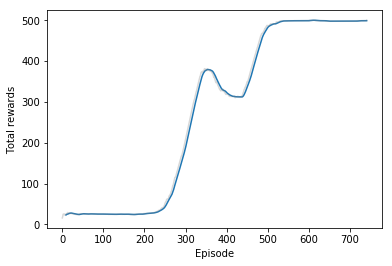

In [23]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

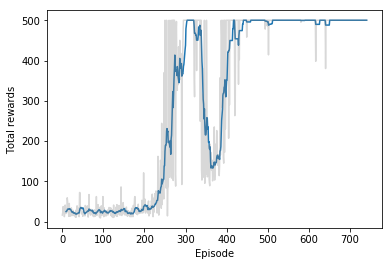

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

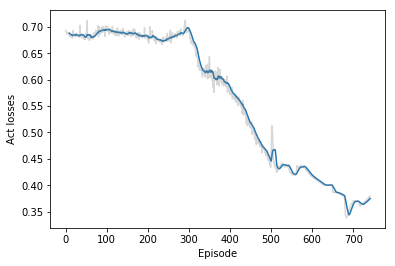

In [25]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

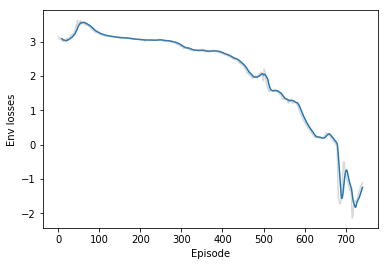

In [26]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

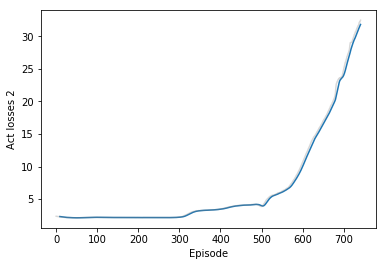

In [27]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
